In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from nldg.rf import MaggingRF
from adaXT.random_forest import RandomForest
from nldg.utils import max_mse

In [2]:
def plot_dtr(
    dtr: pd.DataFrame,
    saveplot: bool = False,
    nameplot: str = "comparison_magging",
):
    data_colors = ["black", "grey", "silver"]
    environments = sorted(dtr["E"].unique())

    fig, ax = plt.subplots(figsize=(8, 5))
    for idx, env in enumerate(environments):
        marker_style = "o"
        ax.scatter(
            dtr[dtr["E"] == env]["X"],
            dtr[dtr["E"] == env]["Y"],
            color=data_colors[idx],
            marker=marker_style,
            alpha=0.5,
            s=30,
            label=f"Env {env + 1}",
        )
    ax.plot(
        dtr["X_sorted"],
        dtr["maxrm"],
        color="#5790FC",
        linewidth=2,
        label="MaxRM-RF(mse)",
    )
    ax.plot(
        dtr["X_sorted"],
        dtr["magging"],
        color="#F89C20",
        linewidth=2,
        label="Magging-RF(mse)",
    )

    x_range = np.linspace(dtr["X_sorted"].min(), dtr["X_sorted"].max(), 1000)
    c = 2.4
    y_opt = np.where(x_range > 0, c * x_range, -c * x_range)
    ax.plot(x_range, y_opt, color="#E42536", linewidth=3, label="Oracle", linestyle="--")

    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.grid(True, linewidth=0.2)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles)

    plt.tight_layout()
    if saveplot:
        script_dir = os.getcwd()
        parent_dir = os.path.abspath(os.path.join(script_dir, "..", ".."))
        plots_dir = os.path.join(parent_dir, "results", "output_additional")
        os.makedirs(plots_dir, exist_ok=True)
        outpath = os.path.join(plots_dir, f"{nameplot}.pdf")
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()

In [3]:
def gen_data(
    n_per_env: int = 500,
    random_state: int = 0,
) -> pd.DataFrame:
    """
    Generate data for three environments with X drawn from mixtures of uniforms:
      Env 1 & 3: X ~ 0.9 U(0,4) + 0.1 U(-4,0)
      Env 2:     X ~ 0.1 U(0,4) + 0.9 U(-4,0)
    And Y = c_e * X + N(0, noise_std^2).
    """
    rng = np.random.default_rng(random_state)
    p_pos_env = (0.9, 0.1, 0.9)
    # p_pos_env = (0.5, 0.5, 0.5)
    pos_interval = (0.0, 4.0)
    neg_interval = (-4.0, 0.0)
    slopes = (3.0, -3.0, 2.0)
    noise_std = 1.0

    def sample_X(n, p_pos, rng):
        mask = rng.random(n) < p_pos  # True -> draw from U(0,4), False -> U(-4,0)
        x = np.empty(n, dtype=float)
        x[mask] = rng.uniform(pos_interval[0], pos_interval[1], mask.sum())
        x[~mask] = rng.uniform(neg_interval[0], neg_interval[1], (~mask).sum())
        return x

    # Sample X per environment
    x_e1 = sample_X(n_per_env, p_pos_env[0], rng)
    x_e2 = sample_X(n_per_env, p_pos_env[1], rng)
    x_e3 = sample_X(n_per_env, p_pos_env[2], rng)

    # Add noise and form Y = slope * X + noise
    eps1 = rng.normal(0.0, noise_std, size=n_per_env)
    eps2 = rng.normal(0.0, noise_std, size=n_per_env)
    eps3 = rng.normal(0.0, noise_std, size=n_per_env)

    y_e1 = slopes[0] * x_e1 + eps1
    y_e2 = slopes[1] * x_e2 + eps2
    y_e3 = slopes[2] * x_e3 + eps3

    df_e1 = pd.DataFrame({"X": x_e1, "Y": y_e1, "E": 0})
    df_e2 = pd.DataFrame({"X": x_e2, "Y": y_e2, "E": 1})
    df_e3 = pd.DataFrame({"X": x_e3, "Y": y_e3, "E": 2})

    df = pd.concat([df_e1, df_e2, df_e3], ignore_index=True)
    return df

In [4]:
dtr = gen_data(random_state=123)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 100
random_state = 123
min_samples_leaf = 15

dte = gen_data(random_state=1)
Xte = np.array(dte.drop(columns=['E', 'Y']))
Yte = np.array(dte['Y'])
Ete = np.array(dte['E'])

In [5]:
# Optimal values
z = cp.Variable(nonneg=True)
cplus = cp.Variable()
cminus = cp.Variable()

constraints = []
constraints.append(24/5 * (3-cplus)**2 + 8/15 * (3-cminus)**2 + 1 <= z)
constraints.append(8/15 * (-3-cplus)**2 + 24/5 * (-3-cminus)**2 + 1 <= z)
constraints.append(24/5 * (2-cplus)**2 + 8/15 * (2-cminus)**2 + 1 <= z)

objective = cp.Minimize(z)
problem = cp.Problem(objective, constraints)
problem.solve()

cplus, cminus = cplus.value, cminus.value

In [6]:
problem.value

np.float64(18.279999837262938)

In [7]:
cplus, cminus

(array(2.39996983), array(-2.39996983))

In [8]:
# Magging
z = cp.Variable(nonneg=True)
q1, q2, q3 = cp.Variable(nonneg=True), cp.Variable(nonneg=True), cp.Variable(nonneg=True)

constraints = []
constraints.append(16/3 * (3 - (3*q1 - 3*q2 + 2*q3))**2 + 1 <= z)
constraints.append(16/3 * (-3 - (3*q1 - 3*q2 + 2*q3))**2 + 1 <= z)
constraints.append(16/3 * (2 - (3*q1 - 3*q2 + 2*q3))**2 + 1 <= z)
constraints.append(q1 + q2 + q3 == 1)

objective = cp.Minimize(z)
problem = cp.Problem(objective, constraints)
problem.solve()

q1, q2, q3 = q1.value, q2.value, q3.value

In [9]:
problem.value

np.float64(48.99999984625573)

In [10]:
q1, q2, q3

(np.float64(0.2684236290203526),
 np.float64(0.4536847258586945),
 np.float64(0.27789164512095277))

In [11]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
rf.modify_predictions_trees(Etr)
fitted_maxrm = rf.predict(Xtr)
preds_maxrm = rf.predict(Xtr_sorted)
preds_maxrm_te = rf.predict(Xte)
max_mse(Yte, preds_maxrm_te, Etr, verbose=True)

Environment 0 MSE: 16.16275756994414
Environment 1 MSE: 17.996317759597556
Environment 2 MSE: 13.702698983368554


np.float64(17.996317759597556)

In [12]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
    risk="mse",
)
fitted_magging = rf_magging.fit(Xtr, Ytr, Etr)
preds_magging = rf_magging.predict(Xtr_sorted)
preds_magging_te = rf_magging.predict(Xte)
wmag = rf_magging.get_weights()

max_mse(Yte, preds_magging_te, Etr, verbose=True)

Environment 0 MSE: 46.48347589164311
Environment 1 MSE: 43.11437797818437
Environment 2 MSE: 19.891906675651413


np.float64(46.48347589164311)

In [13]:
wmag

array([4.32100121e-08, 4.08935980e-01, 5.91063977e-01])

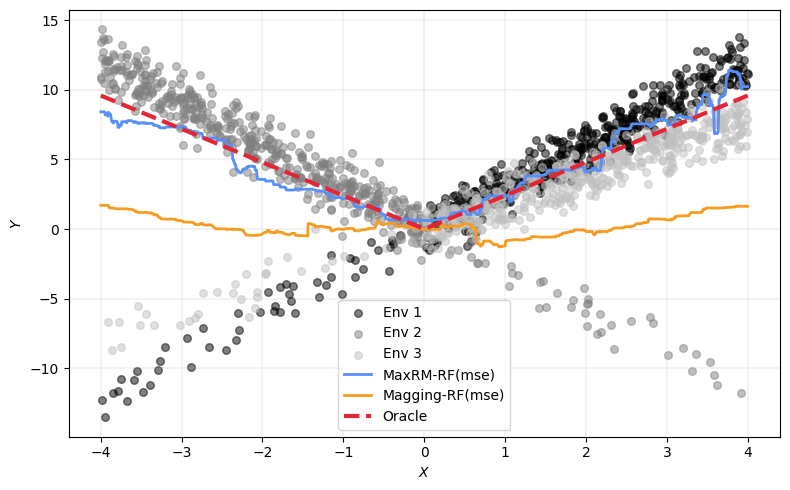

In [14]:
dtr["X_sorted"] = Xtr_sorted
dtr["maxrm"] = preds_maxrm
dtr["magging"] = preds_magging

plot_dtr(dtr, saveplot=True)